In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from pygam import LogisticGAM, s, f
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import time
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
X_train, X_test, y_train, y_test = pd.read_csv('X_train.csv'), pd.read_csv('X_test.csv'), pd.read_csv('y_train.csv'), pd.read_csv('y_test.csv')

In [4]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [5]:
for col in cat_cols:
    dummies = pd.get_dummies(X_train[col], prefix=col, drop_first=True)
    X_train = pd.concat([X_train, dummies], axis=1)

    test_dummies = pd.get_dummies(X_test[col], prefix=col, drop_first=True)

    for dummy_col in dummies.columns:
        if dummy_col not in test_dummies.columns:
            test_dummies[dummy_col] = 0
    
    X_test = pd.concat([X_test, test_dummies], axis=1)

X_train.drop(cat_cols, axis=1, inplace=True)
X_test.drop(cat_cols, axis=1, inplace=True)

In [6]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [7]:
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [8]:
print("Data preprocessing complete.")
print(f"Normalized {len(num_cols)} numerical features.")
print(f"Total features after encoding: {X_train_scaled.shape[1]}")

Data preprocessing complete.
Normalized 5 numerical features.
Total features after encoding: 28


Definition of a function to evaluate models

In [9]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate a model on training and test data, printing key metrics.
    """
    # Predict on test data
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{model_name} Evaluation")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot confusion matrix and ROC curve
    plt.figure(figsize=(18, 6))
    
    # Confusion Matrix
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # ROC curve if predict_proba is available
    if y_prob is not None:
        plt.subplot(1, 3, 2)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics in a dictionary
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if y_prob is not None else None,
        'model': model
    }
    
    return metrics

In [10]:
# Define a function for cross-validation with stratification
def cross_val_recall_score(model, X, y, cv=5):
    """Calculate cross-validated F1 score with stratification."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='recall')
    return scores.mean()

# Track all model results
all_metrics = []

Model 1 KNN:

- Non-parametric: Does not make assumptions about the underlying data distribution
- Main tuning parameters: k (number of neighbors), distance metric
- Not designed for inference; works as a black-box model
- Does not perform variable selection inherently
- Standardization is crucial as it uses distance metrics

In [11]:
# 3. MODEL 1: k-Nearest Neighbors (kNN)
print("\n" + "="*80)
print("MODEL 1: k-NEAREST NEIGHBORS (kNN)")
print("="*80)


MODEL 1: k-NEAREST NEIGHBORS (kNN)


Optimizing kNN parameters with Hyperopt...
100%|██████████| 10/10 [01:22<00:00,  8.25s/trial, best loss: -0.502888778436094] 
Optimization completed in 82.49 seconds.
Best kNN parameters: {'n_neighbors': 5.0}

k-Nearest Neighbors Evaluation
--------------------------------------------------
Accuracy: 0.8639
Precision: 0.8848
Recall: 0.5116
F1 Score: 0.6483
ROC AUC: 0.8056


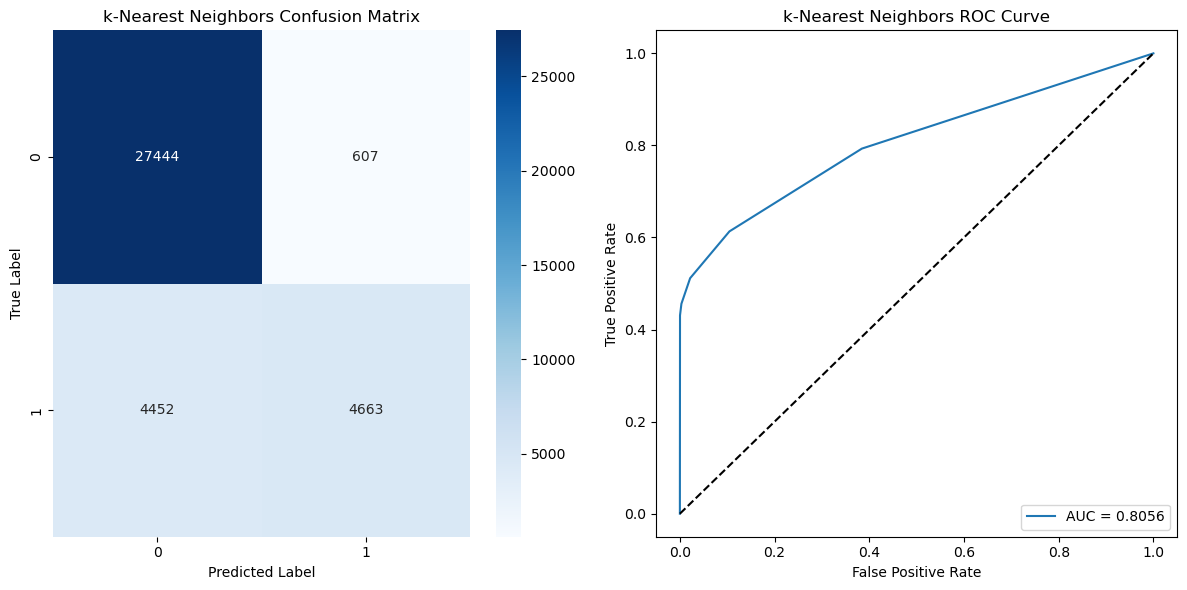

In [13]:
# Define hyperparameter space for kNN
knn_space = {
    'n_neighbors': hp.quniform('n_neighbors', 5, 40, 5),
}

# Define objective function for kNN
def knn_objective(params):
    # Convert float parameters to int
    params['n_neighbors'] = int(params['n_neighbors'])
    
    # Create model with given parameters
    model = KNeighborsClassifier(**params)
    
    # Cross-validation score (negative because hyperopt minimizes)
    score = cross_val_recall_score(model, X_train_scaled, y_train)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

# Run hyperopt optimization
print("Optimizing kNN parameters with Hyperopt...")
start_time = time.time()
knn_trials = Trials()
knn_best = fmin(
    knn_objective,
    space=knn_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=knn_trials
)
end_time = time.time()

print(f"Optimization completed in {end_time - start_time:.2f} seconds.")
print(f"Best kNN parameters: {space_eval(knn_space, knn_best)}")

# Get the best model
best_idx = np.argmin([t['loss'] for t in knn_trials.results])
knn_best_model = knn_trials.results[best_idx]['model']

#Fit full training data on the Best Model
knn_best_model.fit(X_train_scaled, y_train)

# Evaluate kNN model
knn_metrics = evaluate_model(knn_best_model, X_train_scaled, y_train, X_test_scaled, y_test, "k-Nearest Neighbors")
all_metrics.append(knn_metrics)

In [14]:
# 4. MODEL 2: Logistic Regression
print("\n" + "="*80)
print("MODEL 2: LOGISTIC REGRESSION with L1 or L2 Regularization")
print("="*80)

print("""
Model Characteristics:
- Parametric: Assumes linear relationship between features and log-odds of the outcome
- Tuning parameters: lambda (regularization coefficient), penalty type (L1, L2)
- Good for inference: Provides coefficients that can be interpreted as log-odds
- Can perform variable selection with L1 regularization
- Standardization is beneficial for regularized models
""")


MODEL 2: LOGISTIC REGRESSION with L1 or L2 Regularization

Model Characteristics:
- Parametric: Assumes linear relationship between features and log-odds of the outcome
- Tuning parameters: lambda (regularization coefficient), penalty type (L1, L2)
- Good for inference: Provides coefficients that can be interpreted as log-odds
- Can perform variable selection with L1 regularization
- Standardization is beneficial for regularized models



In [15]:
# Define hyperparameter space for Logistic Regression
lr_space = {
    'C': hp.loguniform('C', np.log(0.01), np.log(300)),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'solver': hp.choice('solver', ['liblinear', 'saga']),
    'class_weight': hp.choice('class_weight', ['balanced', None]),
    'max_iter': hp.choice('max_iter', [100, 250, 500])
}

In [16]:
def lr_objective(params):
    # Create model with given parameters
    model = LogisticRegression(random_state=42, **params)
    
    # Cross-validation score (negative because hyperopt minimizes)
    score = cross_val_recall_score(model, X_train_scaled, y_train)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [17]:
print("Optimizing Logistic Regression parameters with Hyperopt...")
start_time = time.time()
lr_trials = Trials()
lr_best = fmin(
    lr_objective,
    space=lr_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=lr_trials
)
end_time = time.time()

print(f"Optimization completed in {end_time - start_time:.2f} seconds.")
print(f"Best Logistic Regression parameters: {space_eval(lr_space, lr_best)}")

Optimizing Logistic Regression parameters with Hyperopt...
100%|██████████| 10/10 [04:32<00:00, 27.27s/trial, best loss: -0.6187193262467525]
Optimization completed in 272.74 seconds.
Best Logistic Regression parameters: {'C': 1.118982358762616, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}



Logistic Regression Evaluation
--------------------------------------------------
Accuracy: 0.8244
Precision: 0.6487
Recall: 0.6192
F1 Score: 0.6336
ROC AUC: 0.8286


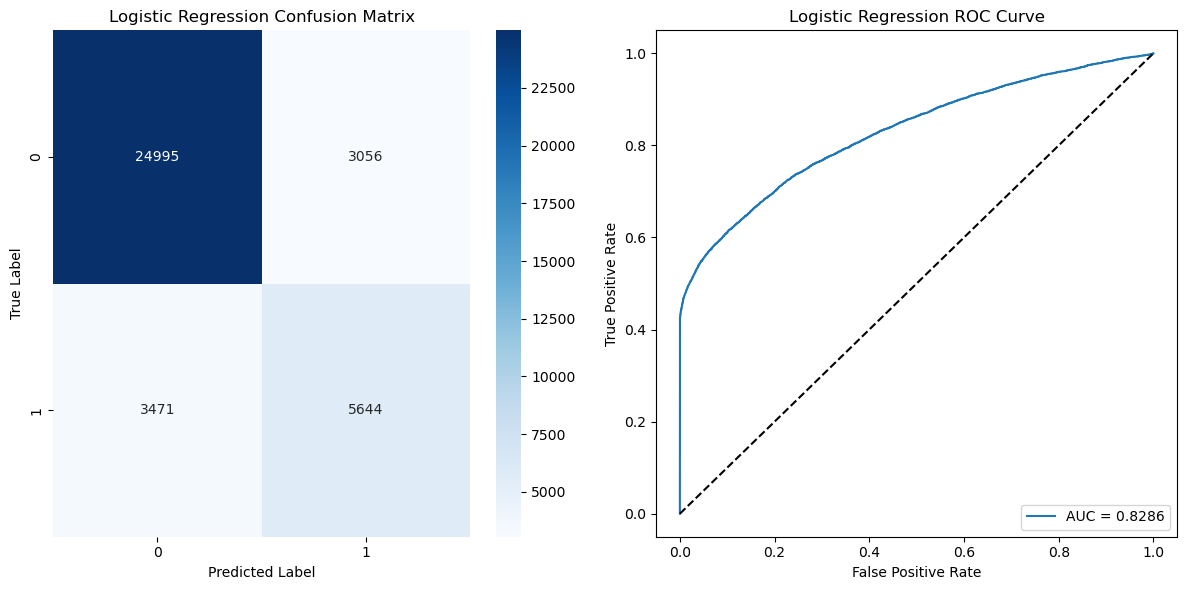

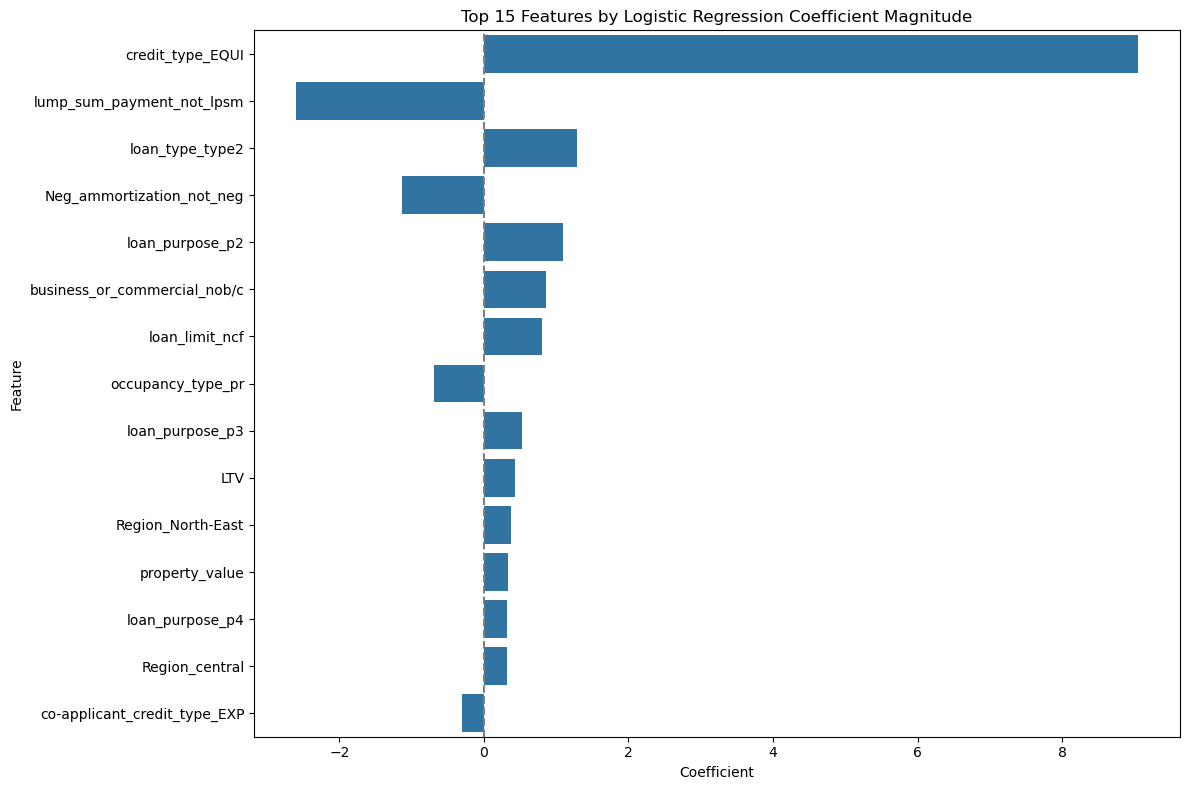

In [18]:
# Get the best model
best_idx = np.argmin([t['loss'] for t in lr_trials.results])
lr_best_model = lr_trials.results[best_idx]['model']

lr_best_model = lr_best_model.fit(X_train_scaled, y_train)

# Evaluate Logistic Regression model
lr_metrics = evaluate_model(lr_best_model, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")
all_metrics.append(lr_metrics)

# Analyze feature importance for Logistic Regression
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_best_model.coef_[0]
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
top_features = coef_df.head(15)
sns.barplot(x='Coefficient', y='Feature', data=top_features)
plt.title('Top 15 Features by Logistic Regression Coefficient Magnitude')
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [19]:
print("\n" + "="*80)
print("MODEL 3: GENERALIZED ADDITIVE MODELS (GAMs)")
print("="*80)

print("""
Model Characteristics:
- Semi-parametric: Combines linear model interpretability with non-linear flexibility
- Main tuning parameters: 
  * n_splines: Controls the number of basis functions (complexity)
  * lam: Controls smoothing regularization
  * spline_order: Polynomial order of the splines
- Excellent for inference: Shows exact shape of feature-target relationships
- Automatically detects non-linear patterns
- Natural splines enforce boundary constraints (linear beyond boundaries)
""")


MODEL 3: GENERALIZED ADDITIVE MODELS (GAMs)

Model Characteristics:
- Semi-parametric: Combines linear model interpretability with non-linear flexibility
- Main tuning parameters: 
  * n_splines: Controls the number of basis functions (complexity)
  * lam: Controls smoothing regularization
  * spline_order: Polynomial order of the splines
- Excellent for inference: Shows exact shape of feature-target relationships
- Automatically detects non-linear patterns
- Natural splines enforce boundary constraints (linear beyond boundaries)



In [20]:
top_features = ['Credit_Worthiness_l2', 'credit_type_EQUI', 'credit_type_EXP', 'credit_type_CRIF', 'loan_purpose_p3', 'loan_purpose_p2', 'Region_south',
                'Region_central', 'Region_North-East', 'dtir1', 'LTV', 'property_value']

#using these features because the overhead for GAMS is high
# these are the top features from logistic reg coeff and main numeric features i consider are important

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from pygam import LogisticGAM, s, f
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import time
from functools import reduce
import operator

# Define hyperparameter space for GAM
gam_space = {
    'n_splines': hp.choice('n_splines', [10, 20, 30]),
    'lam': hp.loguniform('lam', np.log(0.01), np.log(100))
}

# Manual cross-validation function to avoid cloning issues
def manual_cross_val_f1(params, X, y, cv=3):
    n_splines = params['n_splines']
    lam = params['lam']
    
    # Create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    
    # For each fold
    for train_idx, val_idx in skf.split(X, y):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        gam_terms = [f(i) for i in range(X.shape[1] - 3)] + [s(i, n_splines=n_splines, lam=lam) for i in range(X.shape[1] - 3, X.shape[1])]
        gam_expression = reduce(operator.add, gam_terms)
        model = LogisticGAM(gam_expression)
        
        try:
            # Fit on this fold's training data
            model.fit(X_fold_train, y_fold_train)
            
            # Predict on validation data
            y_pred = model.predict(X_fold_val)
            
            # Calculate F1 score
            fold_score = f1_score(y_fold_val, y_pred)
            scores.append(fold_score)
        except Exception as e:
            print(f"Error in fold: {e}")
            scores.append(0)  # Penalty for failed fold
    
    # Return mean F1 score across folds
    mean_score = np.mean(scores)
    return mean_score

# Objective function for hyperopt
def gam_objective(params):
    try:
        score = manual_cross_val_f1(params, X_train_scaled[top_features].values, y_train.values)
        return {'loss': -score, 'status': STATUS_OK, 'score': score}
    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        return {'loss': 1, 'status': STATUS_OK}  # Return max loss on error

# Run hyperopt optimization
print("Optimizing GAM parameters with Hyperopt...")
trials = Trials()
best_params = fmin(
    gam_objective,
    space=gam_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

Optimizing GAM parameters with Hyperopt...
did not converge                                                                
did not converge                                                                
did not converge                                                                 
did not converge                                                                 
did not converge                                                                 
did not converge                                                                 
100%|██████████| 10/10 [09:09<00:00, 54.94s/trial, best loss: -0.6150681251651146]



GAM Evaluation
--------------------------------------------------
Accuracy: 0.8593
Precision: 0.9233
Recall: 0.4648
F1 Score: 0.6184
ROC AUC: 0.8251


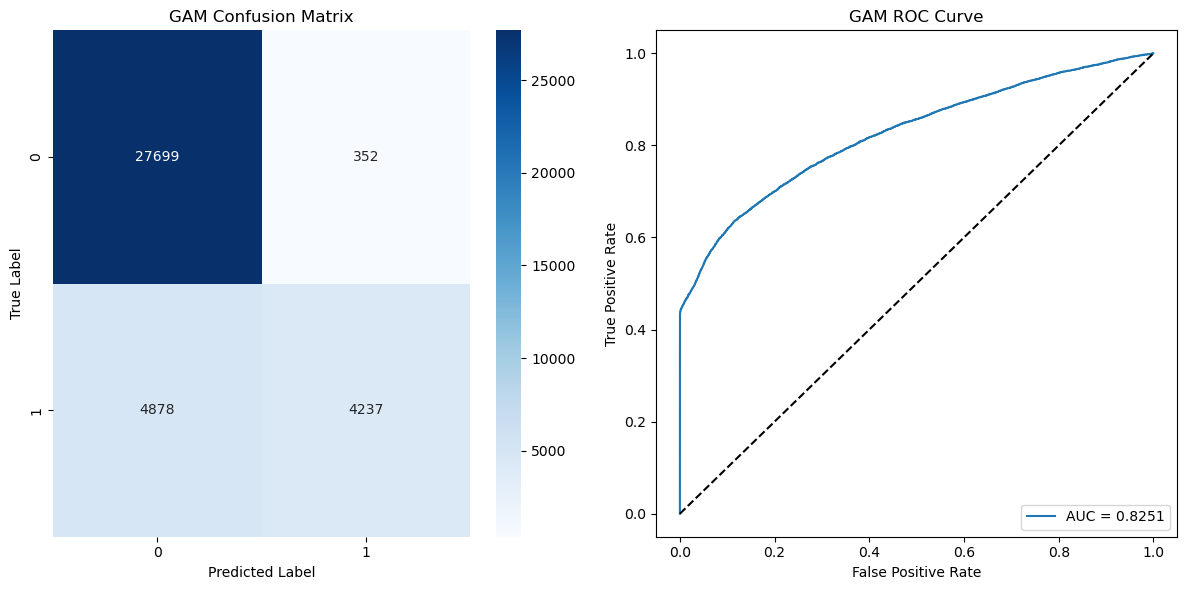

In [22]:
best_gam_params = space_eval(gam_space, best_params)
lam, n_splines = best_gam_params['lam'], best_gam_params['n_splines']

gam_terms = [f(i) for i in range(X_train_scaled[top_features].shape[1] - 3)] + [s(i, n_splines=n_splines, lam=lam) for i in range(X_train_scaled[top_features].shape[1] - 3, X_train_scaled[top_features].shape[1])]
gam_expression = reduce(operator.add, gam_terms)
gam_best_model = LogisticGAM(gam_expression)

gam_best_model.fit(X_train_scaled[top_features], y_train)

# Store the original method that gets raw probabilities
gam_best_model._predict_proba_raw = gam_best_model.predict_proba

# Create a new method that formats probabilities correctly
def formatted_predict_proba(X):
    # Call the original raw probability method
    probas = gam_best_model._predict_proba_raw(X)
    # Return in the format expected by sklearn (two columns)
    return np.column_stack((1 - probas, probas))

# Now assign the new method
gam_best_model.predict_proba = formatted_predict_proba

# Evaluate GAM model
gam_metrics = evaluate_model(gam_best_model, X_train_scaled[top_features], y_train, X_test_scaled[top_features], y_test, "GAM")
all_metrics.append(gam_metrics)

In [23]:
print("\n" + "="*80)
print("MODEL 4: DECISION TREE")
print("="*80)

print("""
Model Characteristics:
- Non-parametric: Makes no assumptions about the functional form
- Tuning parameters: max_depth, min_samples_split, min_samples_leaf, etc.
- Good for inference: Provides clear decision rules, easy to interpret
- Inherently performs variable selection
- Standardization is not required as it's invariant to monotonic transformations
""")


MODEL 4: DECISION TREE

Model Characteristics:
- Non-parametric: Makes no assumptions about the functional form
- Tuning parameters: max_depth, min_samples_split, min_samples_leaf, etc.
- Good for inference: Provides clear decision rules, easy to interpret
- Inherently performs variable selection
- Standardization is not required as it's invariant to monotonic transformations



In [24]:
# Define hyperparameter space for Decision Tree
dt_space = {
    'max_depth': hp.choice('max_depth', [None, *list(range(3, 20))]),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'class_weight': hp.choice('class_weight', [None, 'balanced'])
}

def dt_objective(params):
    # Convert float parameters to int
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    # Create model with given parameters
    model = DecisionTreeClassifier(random_state=42, **params)
    
    # Cross-validation score (negative because hyperopt minimizes)
    score = cross_val_recall_score(model, X_train, y_train)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

print("Optimizing Decision Tree parameters with Hyperopt...")
start_time = time.time()
dt_trials = Trials()
dt_best = fmin(
    dt_objective,
    space=dt_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=dt_trials
)
end_time = time.time()

Optimizing Decision Tree parameters with Hyperopt...
100%|██████████| 10/10 [00:14<00:00,  1.49s/trial, best loss: -0.701958644889424]


In [25]:
print(f"Optimization completed in {end_time - start_time:.2f} seconds.")
print(f"Best Decision Tree parameters: {space_eval(dt_space, dt_best)}")

Optimization completed in 14.93 seconds.
Best Decision Tree parameters: {'class_weight': 'balanced', 'max_depth': 18, 'min_samples_leaf': 10.0, 'min_samples_split': 3.0}


In [26]:
best_idx = np.argmin([t['loss'] for t in dt_trials.results])
dt_best_model = dt_trials.results[best_idx]['model']


Decision Tree Evaluation
--------------------------------------------------
Accuracy: 0.8522
Precision: 0.6987
Recall: 0.6986
F1 Score: 0.6987
ROC AUC: 0.8581


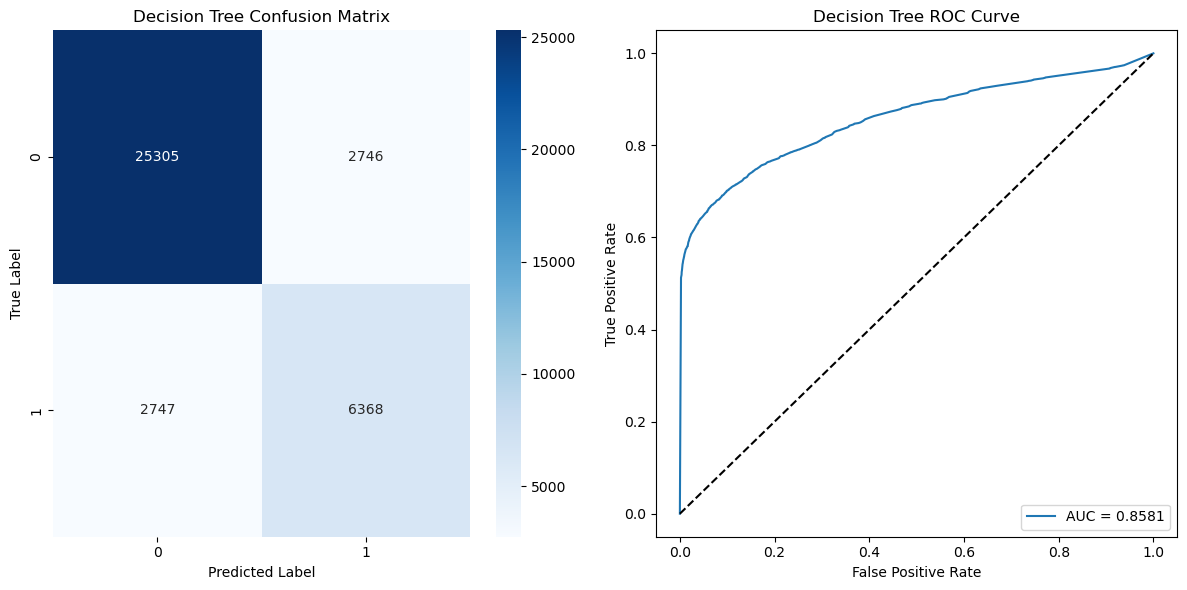

In [27]:
dt_best_model = dt_best_model.fit(X_train, y_train)
dt_metrics = evaluate_model(dt_best_model, X_train, y_train, X_test, y_test, "Decision Tree")
all_metrics.append(dt_metrics)

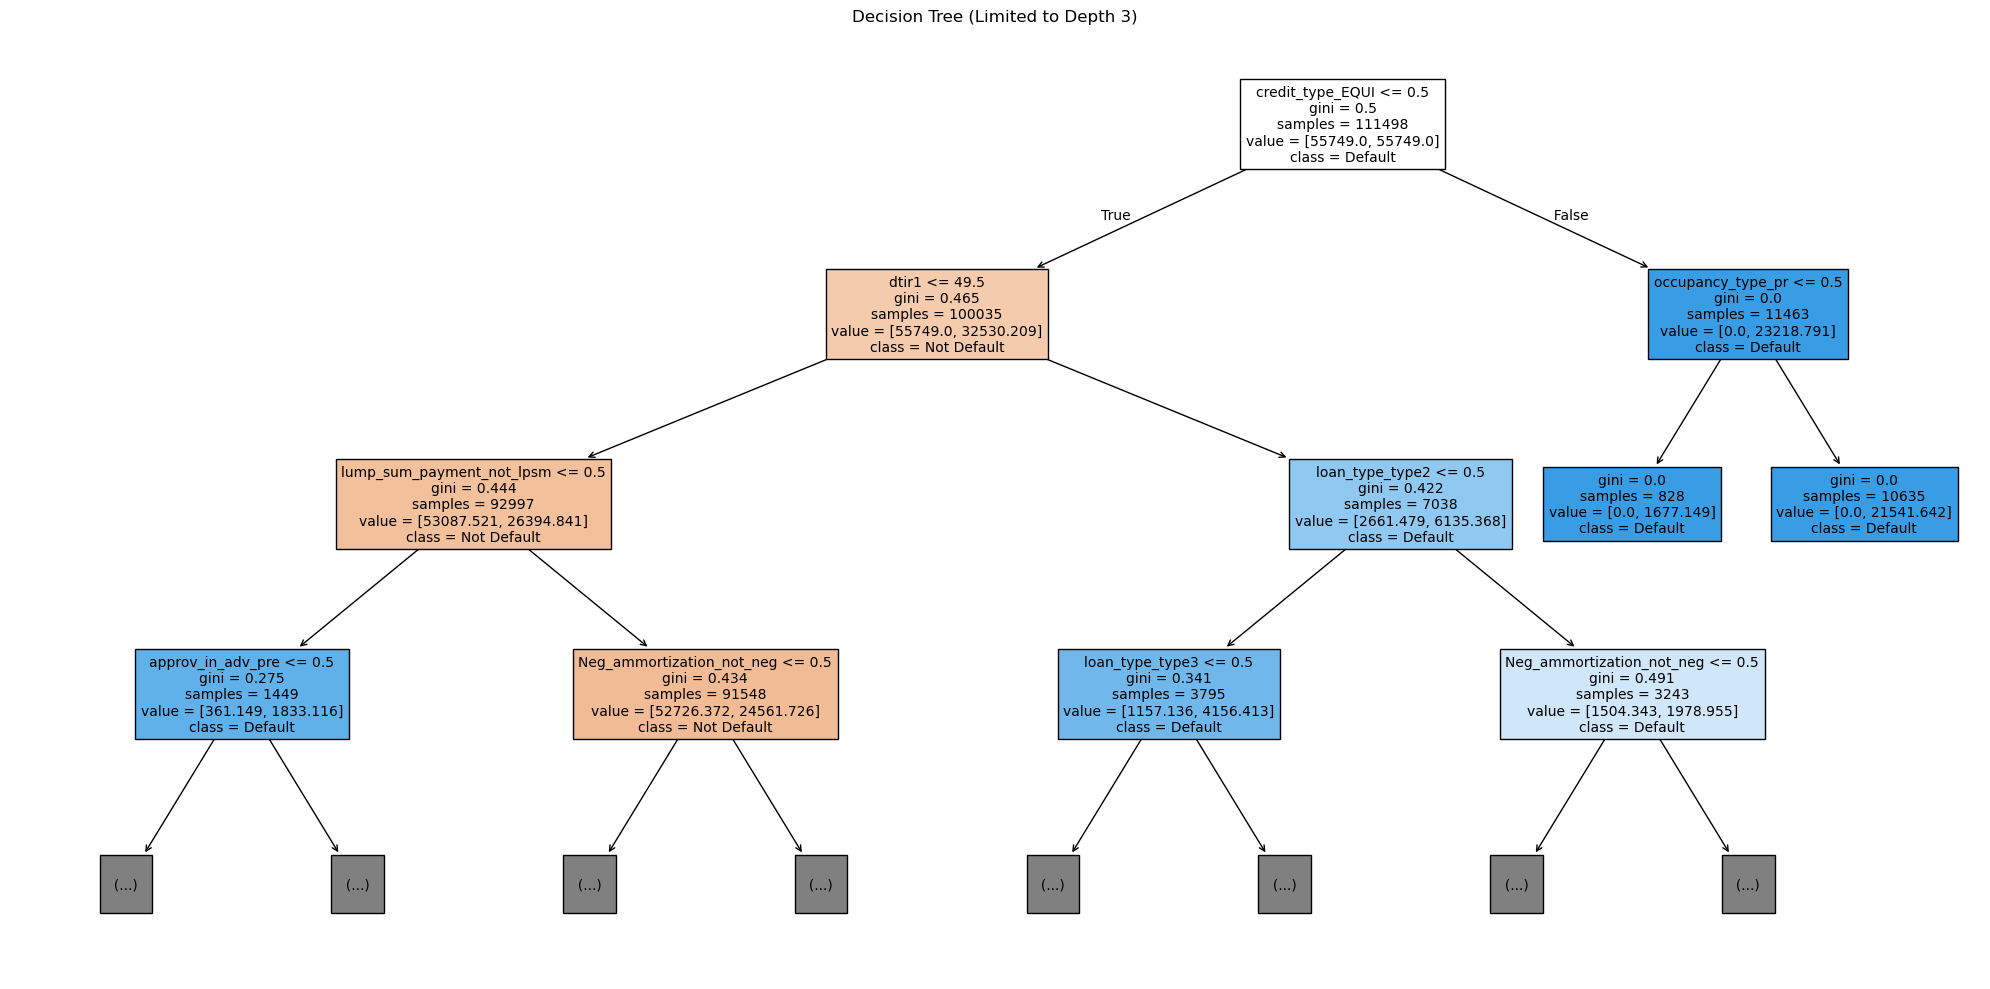

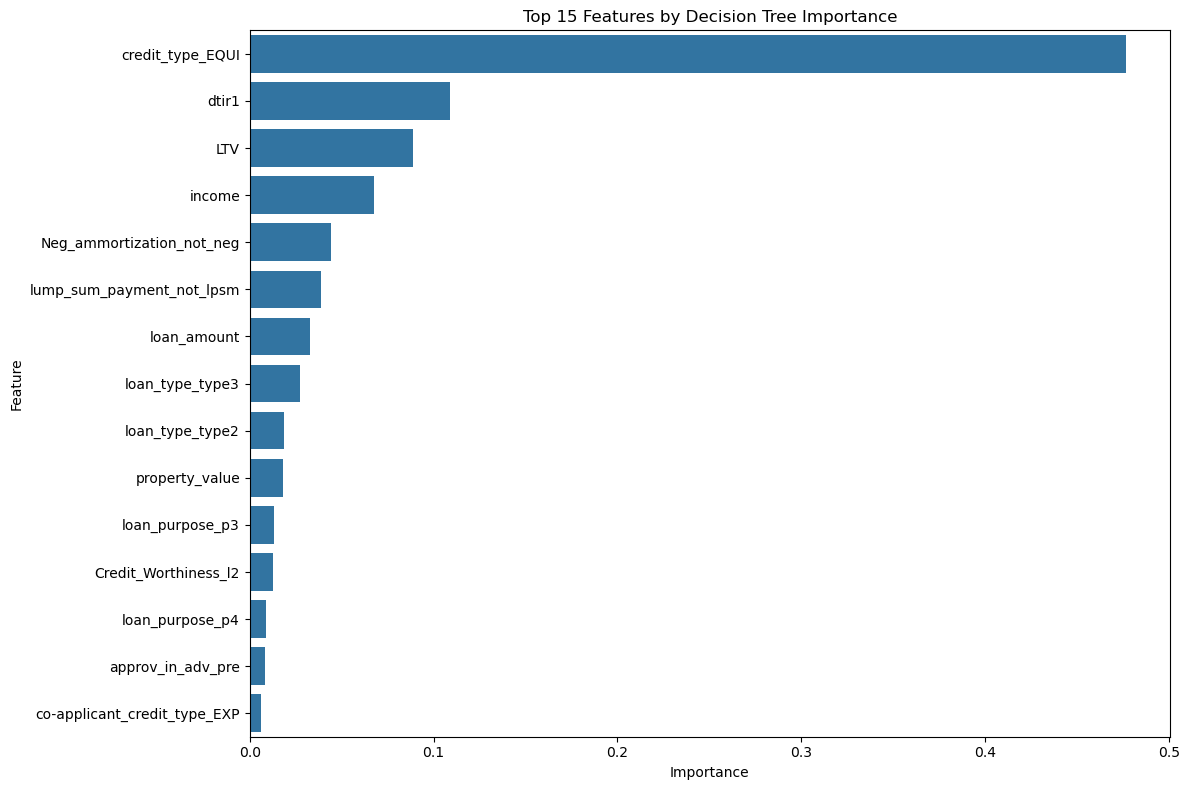

In [28]:
# Visualize decision tree (simplified for readability)
plt.figure(figsize=(20, 10))
max_depth_to_plot = 3  # Limit depth for readability
plot_tree(dt_best_model, max_depth=max_depth_to_plot, feature_names=X_train.columns, 
          class_names=['Not Default', 'Default'], filled=True, fontsize=10)
plt.title(f'Decision Tree (Limited to Depth {max_depth_to_plot})')
plt.tight_layout()
plt.show()

# Feature importance for Decision Tree
dt_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_best_model.feature_importances_
})
dt_feature_importance = dt_feature_importance.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_feature_importance)
plt.title('Top 15 Features by Decision Tree Importance')
plt.tight_layout()
plt.show()

In [29]:
print("\n" + "="*80)
print("MODEL 5: RANDOM FOREST")
print("="*80)

print("""
Model Characteristics:
- Non-parametric ensemble method: Combines multiple decision trees
- Tuning parameters: n_estimators, max_depth, min_samples_split, etc (there are many parameters that can be tuned).
- Limited inference: Provides feature importance but lacks the clarity of a single tree
- Inherently performs feature selection
- Standardization is not required
""")


MODEL 5: RANDOM FOREST

Model Characteristics:
- Non-parametric ensemble method: Combines multiple decision trees
- Tuning parameters: n_estimators, max_depth, min_samples_split, etc (there are many parameters that can be tuned).
- Limited inference: Provides feature importance but lacks the clarity of a single tree
- Inherently performs feature selection
- Standardization is not required



In [30]:
# Define hyperparameter space for Random Forest
rf_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.choice('max_depth', [*list(range(3, 15))]),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', ['sqrt']),
    'class_weight': hp.choice('class_weight', [None, 'balanced'])
}

# Define objective function for Random Forest
def rf_objective(params):
    # Convert float parameters to int
    params['n_estimators'] = int(params['n_estimators'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    # Create model with given parameters
    model = RandomForestClassifier(random_state=42, **params)
    
    # Cross-validation score (negative because hyperopt minimizes)
    score = cross_val_recall_score(model, X_train, y_train)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

# Run hyperopt optimization
print("Optimizing Random Forest parameters with Hyperopt...")
start_time = time.time()
rf_trials = Trials()
rf_best = fmin(
    rf_objective,
    space=rf_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=rf_trials
)
end_time = time.time()

print(f"Optimization completed in {end_time - start_time:.2f} seconds.")
print(f"Best Random Forest parameters: {space_eval(rf_space, rf_best)}")

Optimizing Random Forest parameters with Hyperopt...
100%|██████████| 10/10 [03:18<00:00, 19.89s/trial, best loss: -0.6567599882770421]
Optimization completed in 198.88 seconds.
Best Random Forest parameters: {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 3.0, 'min_samples_split': 15.0, 'n_estimators': 80.0}



Random Forest Evaluation
--------------------------------------------------
Accuracy: 0.8713
Precision: 0.7834
Recall: 0.6567
F1 Score: 0.7145
ROC AUC: 0.8718


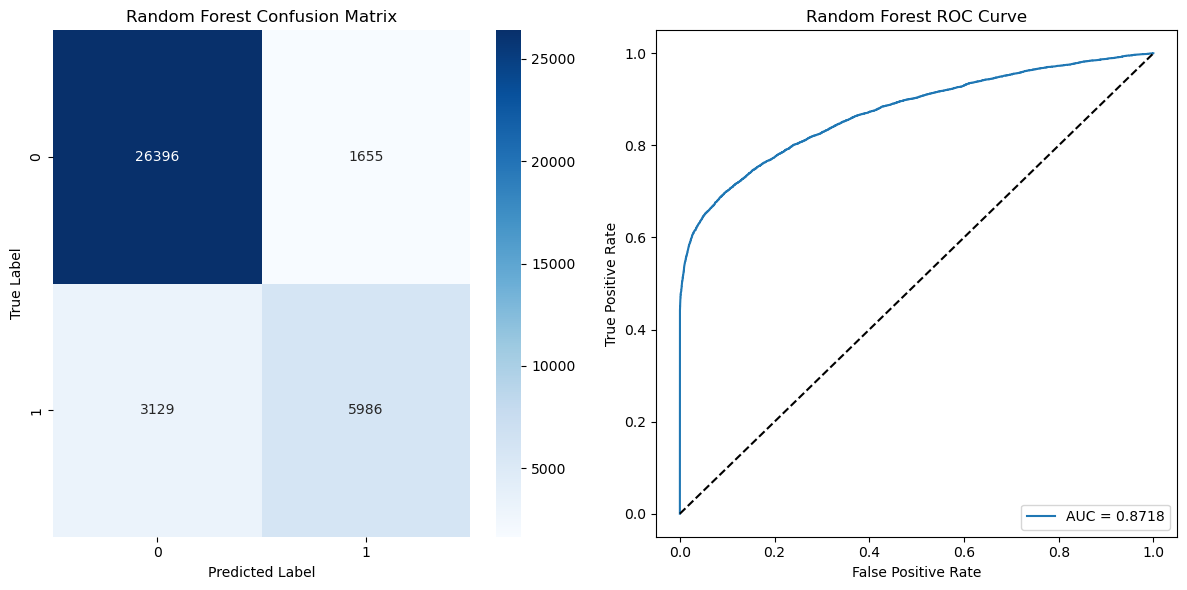

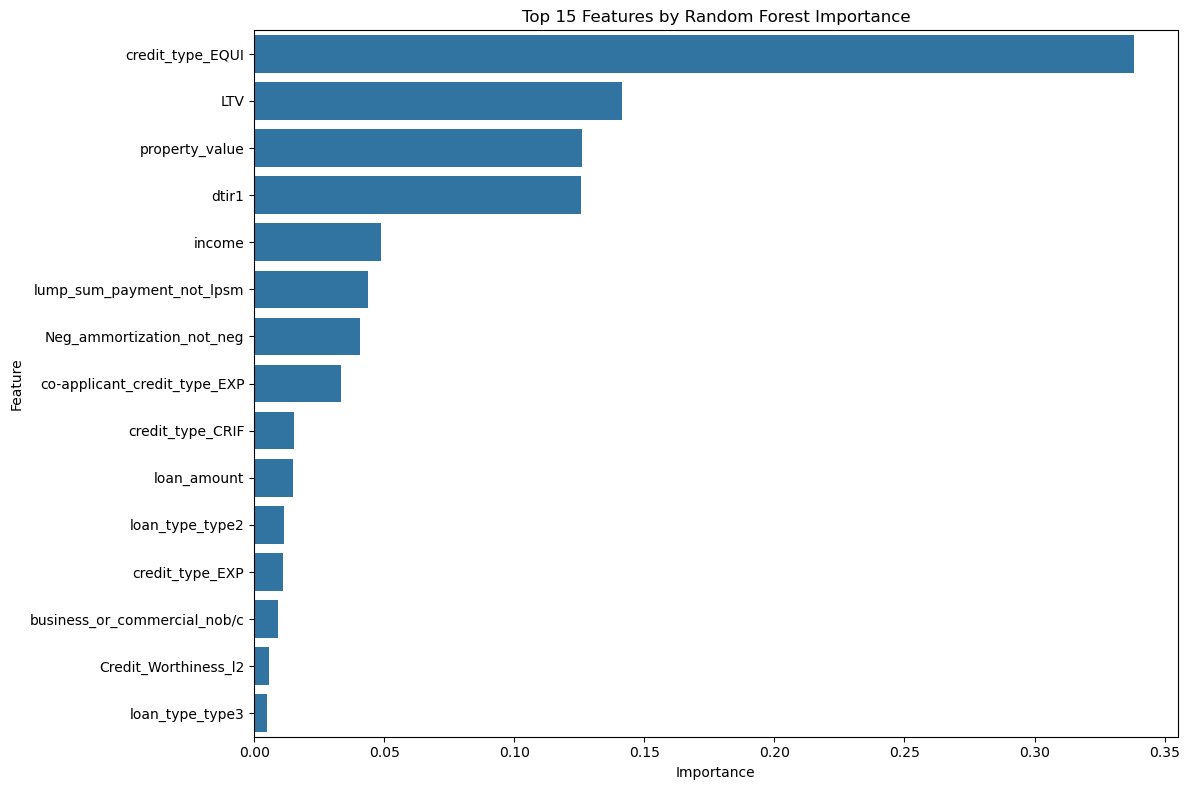

In [31]:
# Get the best model
best_idx = np.argmin([t['loss'] for t in rf_trials.results])
rf_best_model = rf_trials.results[best_idx]['model']

rf_best_model = rf_best_model.fit(X_train, y_train)

# Evaluate Random Forest model
rf_metrics = evaluate_model(rf_best_model, X_train, y_train, X_test, y_test, "Random Forest")
all_metrics.append(rf_metrics)

# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best_model.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance)
plt.title('Top 15 Features by Random Forest Importance')
plt.tight_layout()
plt.show()

In [32]:
# 8. MODEL 6: XGBoost (Advanced Ensemble Tree Model)
print("\n" + "="*80)
print("MODEL 6: XGBOOST")
print("="*80)

print("""
Model Characteristics:
- Non-parametric gradient boosting ensemble
- Tuning parameters: n_estimators, learning_rate, max_depth, etc.
- Limited inference: Provides feature importance but complex internal structure
- Inherently performs feature selection
- Standardization is not required but can help with regularization
""")


MODEL 6: XGBOOST

Model Characteristics:
- Non-parametric gradient boosting ensemble
- Tuning parameters: n_estimators, learning_rate, max_depth, etc.
- Limited inference: Provides feature importance but complex internal structure
- Inherently performs feature selection
- Standardization is not required but can help with regularization



In [33]:
xgb_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.5)),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.loguniform('gamma', np.log(0.001), np.log(500)),

    # Newly added hyperparameters:
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-5), np.log(500)),  # L1 regularization
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-5), np.log(500)),  # L2 regularization
    'booster': hp.choice('booster', ['gbtree']),  # Tree-based methods
}

# Define objective function for XGBoost
def xgb_objective(params):
    # Convert float parameters to int
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    # Create model with given parameters
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        **params, 
    )
    
    # Cross-validation score (negative because hyperopt minimizes)
    score = cross_val_recall_score(model, X_train, y_train)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

# Run hyperopt optimization
print("Optimizing XGBoost parameters with Hyperopt...")
start_time = time.time()
xgb_trials = Trials()
xgb_best = fmin(
    xgb_objective,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=xgb_trials
)
end_time = time.time()

print(f"Optimization completed in {end_time - start_time:.2f} seconds.")
print(f"Best XGBoost parameters: {space_eval(xgb_space, xgb_best)}")


Optimizing XGBoost parameters with Hyperopt...
100%|██████████| 10/10 [01:03<00:00,  6.35s/trial, best loss: -0.6309634344042413]
Optimization completed in 63.50 seconds.
Best XGBoost parameters: {'booster': 'gbtree', 'colsample_bytree': 0.4481142268390975, 'gamma': 0.03378828772636915, 'learning_rate': 0.17868652449444355, 'max_depth': 8.0, 'n_estimators': 370.0, 'reg_alpha': 0.0019976009658817335, 'reg_lambda': 0.05270046474299239, 'subsample': 0.49766705199975725}



XGBoost Evaluation
--------------------------------------------------
Accuracy: 0.8879
Precision: 0.8754
Recall: 0.6328
F1 Score: 0.7346
ROC AUC: 0.8679


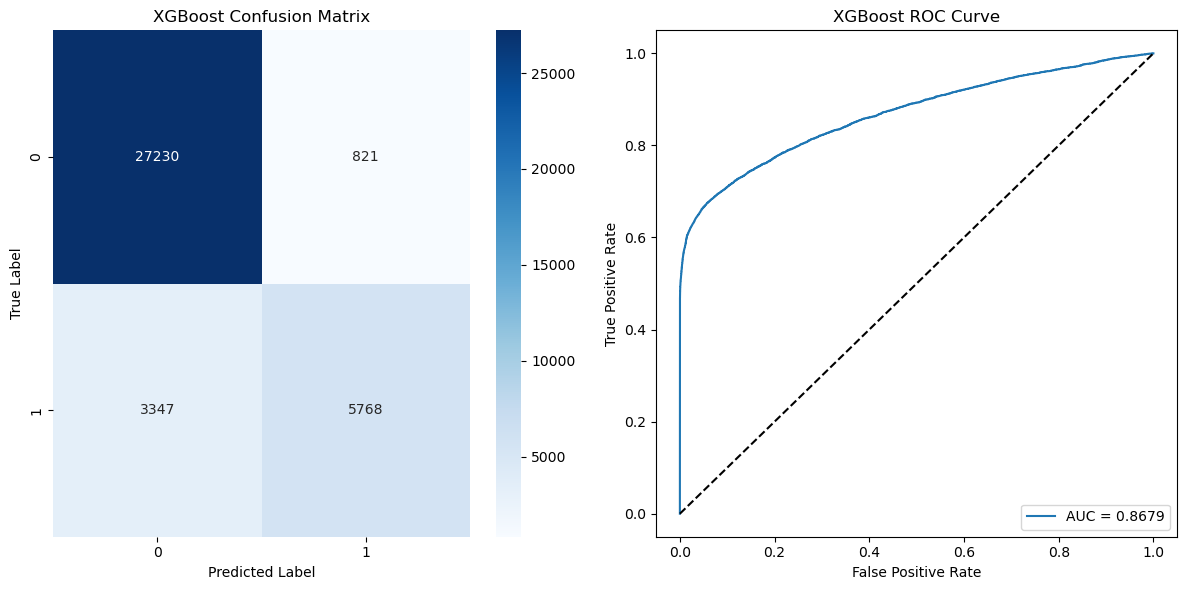

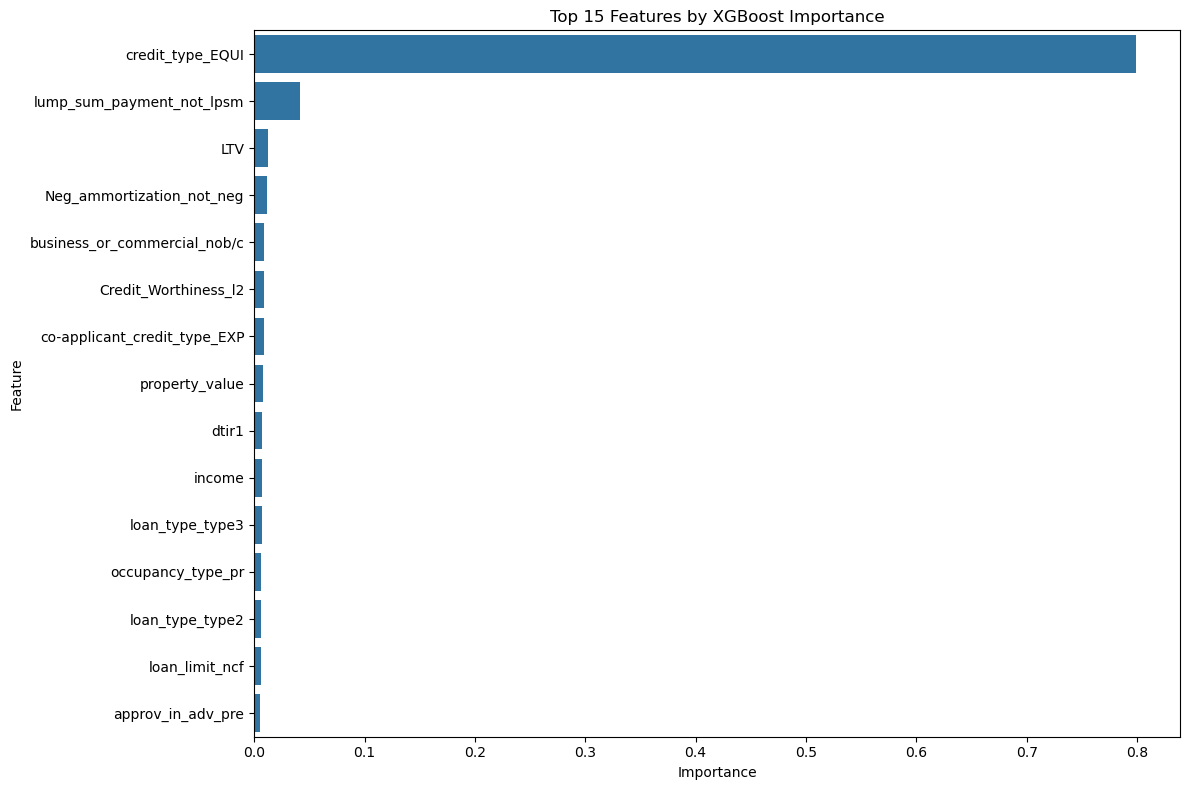

In [34]:
# Get the best model
best_idx = np.argmin([t['loss'] for t in xgb_trials.results])
xgb_best_model = xgb_trials.results[best_idx]['model']

xgb_best_model = xgb_best_model.fit(X_train, y_train)

# Evaluate XGBoost model
xgb_metrics = evaluate_model(xgb_best_model, X_train, y_train, X_test, y_test, "XGBoost")
all_metrics.append(xgb_metrics)

# Feature importance for XGBoost
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_best_model.feature_importances_
})
xgb_feature_importance = xgb_feature_importance.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance)
plt.title('Top 15 Features by XGBoost Importance')
plt.tight_layout()
plt.show()

In [35]:
print("\n" + "="*80)
print("MODEL 7: SUPPORT VECTOR MACHINE")
print("="*80)

print("""
Model Characteristics:
- Discriminative model that finds optimal hyperplane to separate classes
- Tuning parameters: C (regularization), kernel type, gamma, class_weight, penalty type, penalty values, etc (many params to optimize in the library)
- Limited inference capabilities
- Does not perform explicit variable selection
- Standardization is critical for SVM performance
""")


MODEL 7: SUPPORT VECTOR MACHINE

Model Characteristics:
- Discriminative model that finds optimal hyperplane to separate classes
- Tuning parameters: C (regularization), kernel type, gamma, class_weight, penalty type, penalty values, etc (many params to optimize in the library)
- Limited inference capabilities
- Does not perform explicit variable selection
- Standardization is critical for SVM performance



In [36]:
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define the hyperparameter search space
space = {
    'rbf_gamma': hp.choice('rbf_gamma', [0.001, 0.004127991366832073, 0.01]),
    'sgd_alpha': hp.choice('sgd_alpha', [1e-5, 1e-6, 1e-7]),
    'sgd_loss': hp.choice('sgd_loss', ['hinge', 'log_loss']),
    'sgd_penalty': hp.choice('sgd_penalty', ['l2', 'l1', 'elasticnet'])
}

def objective(params):
    # Build a pipeline with RBFSampler and SGDClassifier using the given parameters
    pipeline = Pipeline([
        ('rbf', RBFSampler(gamma=params['rbf_gamma'], random_state=42)),
        ('sgd', SGDClassifier(
            alpha=params['sgd_alpha'],
            loss=params['sgd_loss'],
            penalty=params['sgd_penalty'],
            random_state=42,
            class_weight='balanced'
        ))
    ])
    
    # Use StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Compute mean recall score across folds
    recall = cross_val_score(pipeline, X_train_scaled, y_train, cv=cv, scoring='recall', n_jobs=-1).mean()
    
    # Return negative recall as loss (since hyperopt minimizes the objective)
    return {'loss': -recall, 'status': STATUS_OK}

# Run hyperopt optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=10,  # Adjust as needed
    trials=trials
)


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 10%|█         | 1/10 [00:04<00:43,  4.82s/trial, best loss: -0.5731206897006949]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 20%|██        | 2/10 [00:08<00:32,  4.11s/trial, best loss: -0.6728168367023637]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 30%|███       | 3/10 [00:19<00:49,  7.13s/trial, best loss: -0.6728168367023637]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 40%|████      | 4/10 [00:23<00:35,  5.96s/trial, best loss: -0.6728168367023637]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 50%|█████     | 5/10 [00:25<00:22,  4.50s/trial, best loss: -0.6728168367023637]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 60%|██████    | 6/10 [00:31<00:20,  5.12s/trial, best loss: -0.6728168367023637]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 70%|███████   | 7/10 [00:44<00:23,  7.70s/trial, best loss: -0.6728168367023637]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 80%|████████  | 8/10 [00:50<00:13,  6.99s/trial, best loss: -0.7123523474959339]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

 90%|█████████ | 9/10 [00:58<00:07,  7.44s/trial, best loss: -0.7123523474959339]

/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/testEnvironment/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vecto

100%|██████████| 10/10 [01:05<00:00,  6.57s/trial, best loss: -0.7123523474959339]


In [37]:
print("Best hyperparameters:", space_eval(space, best))

Best hyperparameters: {'rbf_gamma': 0.004127991366832073, 'sgd_alpha': 1e-06, 'sgd_loss': 'log_loss', 'sgd_penalty': 'l1'}


In [38]:
gamma, sgd_alpha, sgd_loss, sgd_penalty = space_eval(space, best).values()


SVM Evaluation
--------------------------------------------------
Accuracy: 0.8481
Precision: 0.7139
Recall: 0.6354
F1 Score: 0.6724
ROC AUC: 0.8516


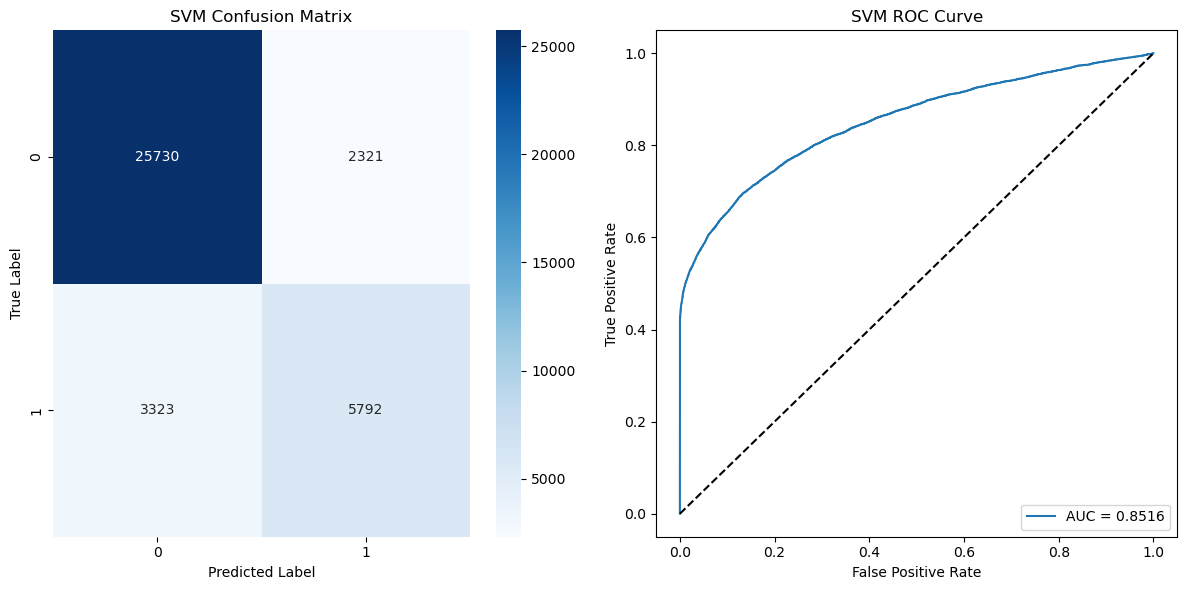

In [43]:
#Using a simpler way to train an SVM model by first using the transform using the RBF kernel and then training the model using stochastic gradient descent

rbf_feature = RBFSampler(gamma=gamma, random_state=42)
X_train_rbf = rbf_feature.fit_transform(X_train_scaled)
X_test_rbf = rbf_feature.transform(X_test_scaled)

sgd_model = SGDClassifier(
    alpha=sgd_alpha,
    loss=sgd_loss,
    penalty=sgd_penalty,
    random_state=42,
    class_weight='balanced'
)
sgd_model.fit(X_train_rbf, y_train)
# Evaluate SGD model
sgd_metrics = evaluate_model(sgd_model, X_train_rbf, y_train, X_test_rbf, y_test, "SVM")
all_metrics.append(sgd_metrics)

In [44]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)


MODEL COMPARISON


Performance metrics across all models:
                     accuracy  precision    recall        f1   roc_auc
model_name                                                            
k-Nearest Neighbors  0.863881   0.884820  0.511574  0.648314  0.805592
Logistic Regression  0.824383   0.648736  0.619199  0.633623  0.828564
GAM                  0.859280   0.923295  0.464838  0.618360  0.825146
Decision Tree        0.852204   0.698705  0.698629  0.698667  0.858099
Random Forest        0.871280   0.783405  0.656720  0.714490  0.871784
XGBoost              0.887854   0.875398  0.632803  0.734590  0.867944
SVM                  0.848141   0.713916  0.635436  0.672394  0.851602


<Figure size 2000x1000 with 0 Axes>

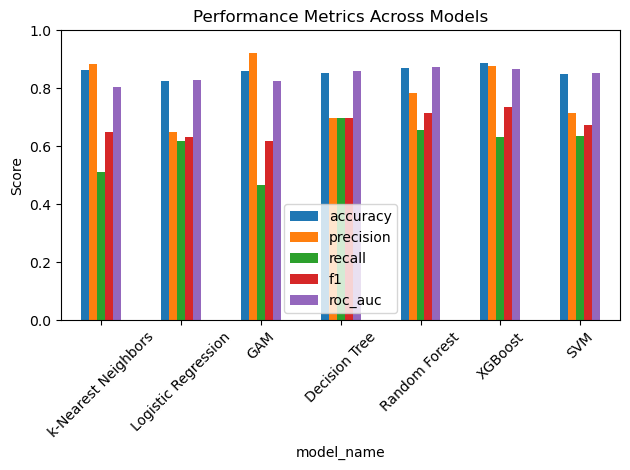

In [52]:
# Create DataFrame with all metrics
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df.set_index('model_name')
comparison_df = comparison_df.drop('model', axis=1)

print("Performance metrics across all models:")
print(comparison_df)

# Plot comparison of models
plt.figure(figsize=(20, 10))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison_df[metrics_to_plot].plot(kind='bar')
plt.title('Performance Metrics Across Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [64]:
best_model_name = comparison_df['recall'].idxmax()
best_model_idx = [i for i, m in enumerate(all_metrics) if m['model_name'] == best_model_name][0]
best_model = all_metrics[best_model_idx]['model']
print(f"\nBest model based on Recall score: {best_model_name}")
print(f"Recall score: {comparison_df.loc[best_model_name, 'recall']:.4f}")
print(f"Precision score: {comparison_df.loc[best_model_name, 'precision']:.4f}")
print(f"F1 score: {comparison_df.loc[best_model_name, 'f1']:.4f}")
print(f"ROC-AUC score: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")
print(f"Accuracy score: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")


Best model based on Recall score: Decision Tree
Recall score: 0.6986
Precision score: 0.6987
F1 score: 0.6987
ROC-AUC score: 0.8581
Accuracy score: 0.8522


In [65]:
# 11. FINAL MODEL ON ENTIRE DATASET
print("\n" + "="*80)
print(f"FITTING BEST MODEL ({best_model_name}) ON ENTIRE DATASET")
print("="*80)


FITTING BEST MODEL (Decision Tree) ON ENTIRE DATASET


In [72]:
X_full = pd.read_csv('X.csv')
y_full = pd.read_csv('y.csv')

for col in cat_cols:
    dummies = pd.get_dummies(X_full[col], prefix=col, drop_first=True)
    X_full = pd.concat([X_full, dummies], axis=1)

# Drop original categorical columns
X_full = X_full.drop(cat_cols, axis=1)

final_model = best_model

In [73]:
final_model.fit(X_full, y_full)

DecisionTreeClassifier(class_weight='balanced', max_depth=18,
                       min_samples_leaf=10, min_samples_split=3,
                       random_state=42)

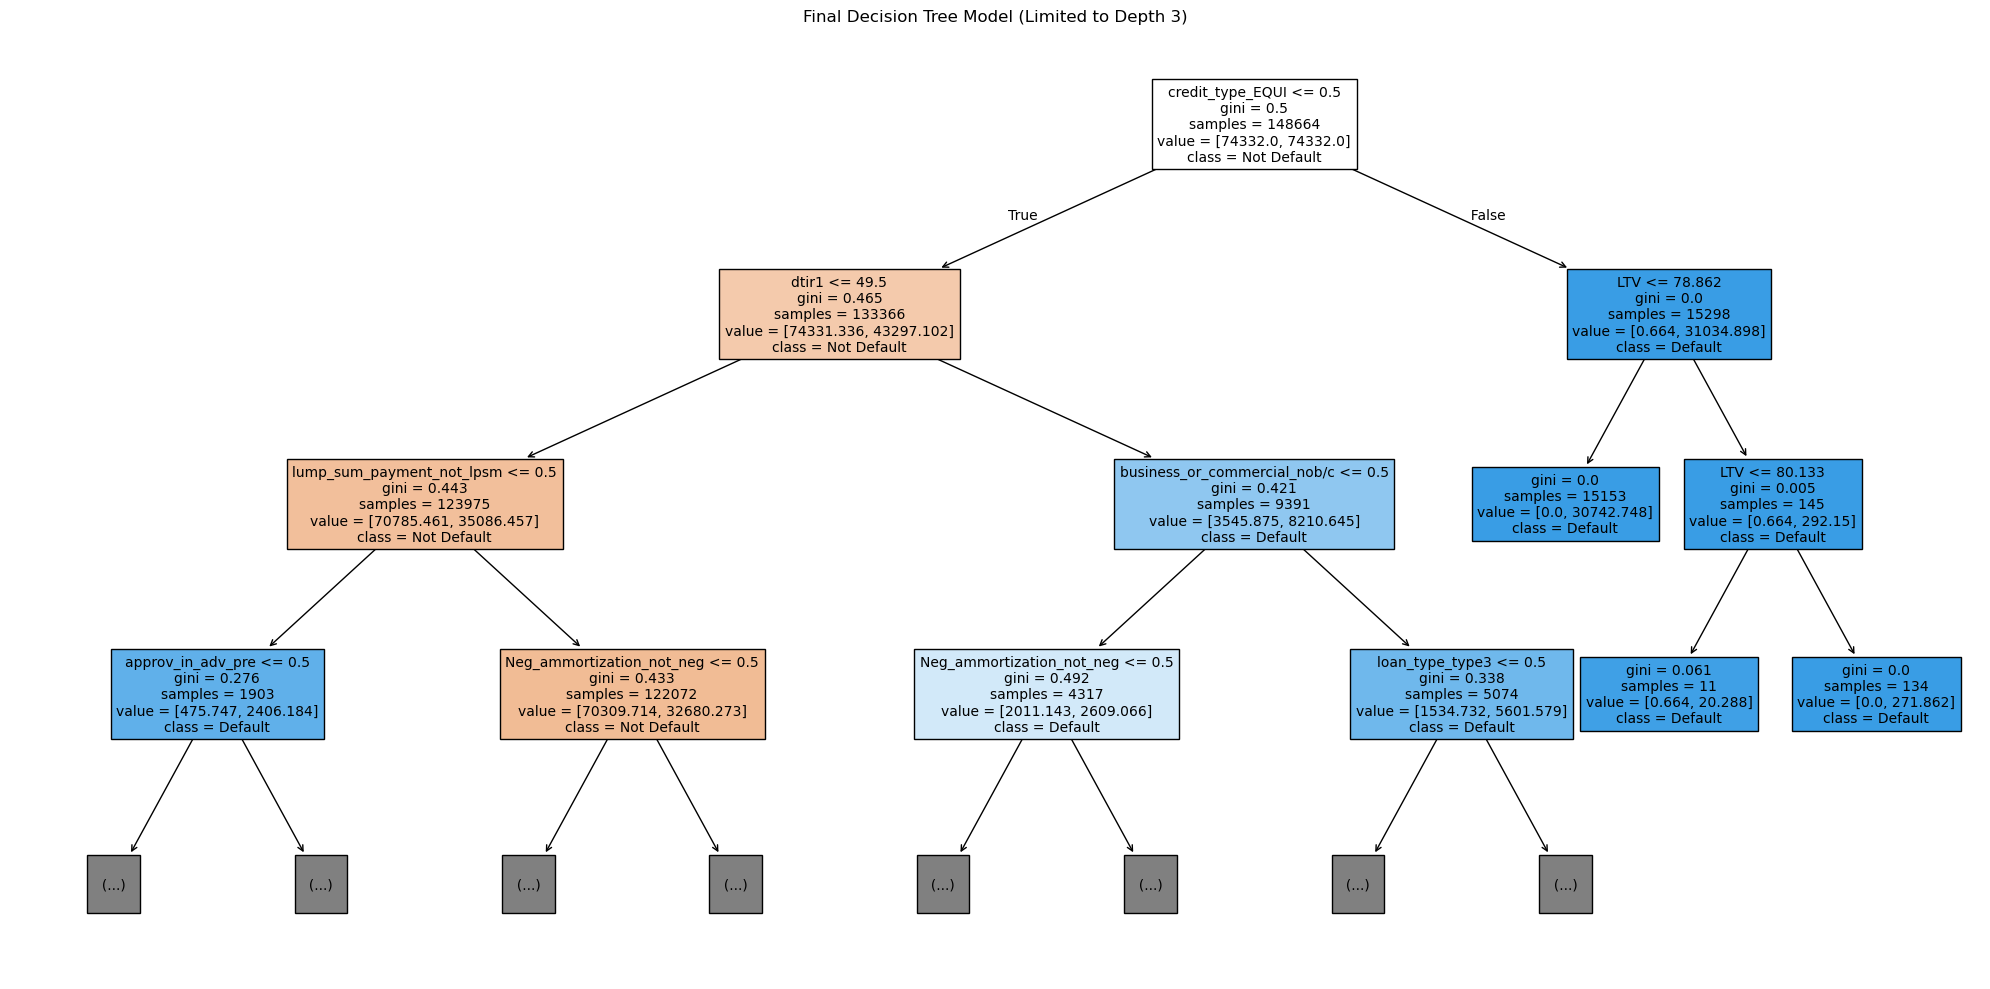

In [77]:
plt.figure(figsize=(20, 10))
plot_tree(final_model, max_depth=3, feature_names=X_full.columns, 
            class_names=['Not Default', 'Default'], filled=True, fontsize=10)
plt.title('Final Decision Tree Model (Limited to Depth 3)')
plt.tight_layout()
plt.show()

Top 20 features by importance:
                         Feature  Importance
22              credit_type_EQUI    0.483219
2                          dtir1    0.106813
3                            LTV    0.084664
0                         income    0.064998
16     Neg_ammortization_not_neg    0.043685
18     lump_sum_payment_not_lpsm    0.039079
1                    loan_amount    0.030955
10               loan_type_type3    0.027582
15  business_or_commercial_nob/c    0.019074
4                 property_value    0.018512
12               loan_purpose_p3    0.014461
14          Credit_Worthiness_l2    0.012387
13               loan_purpose_p4    0.010074
8              approv_in_adv_pre    0.008814
24  co-applicant_credit_type_EXP    0.006020
5                 loan_limit_ncf    0.005059
19             occupancy_type_pr    0.004944
17         interest_only_not_int    0.003622
27                  Region_south    0.003427
7                    Gender_Male    0.002726


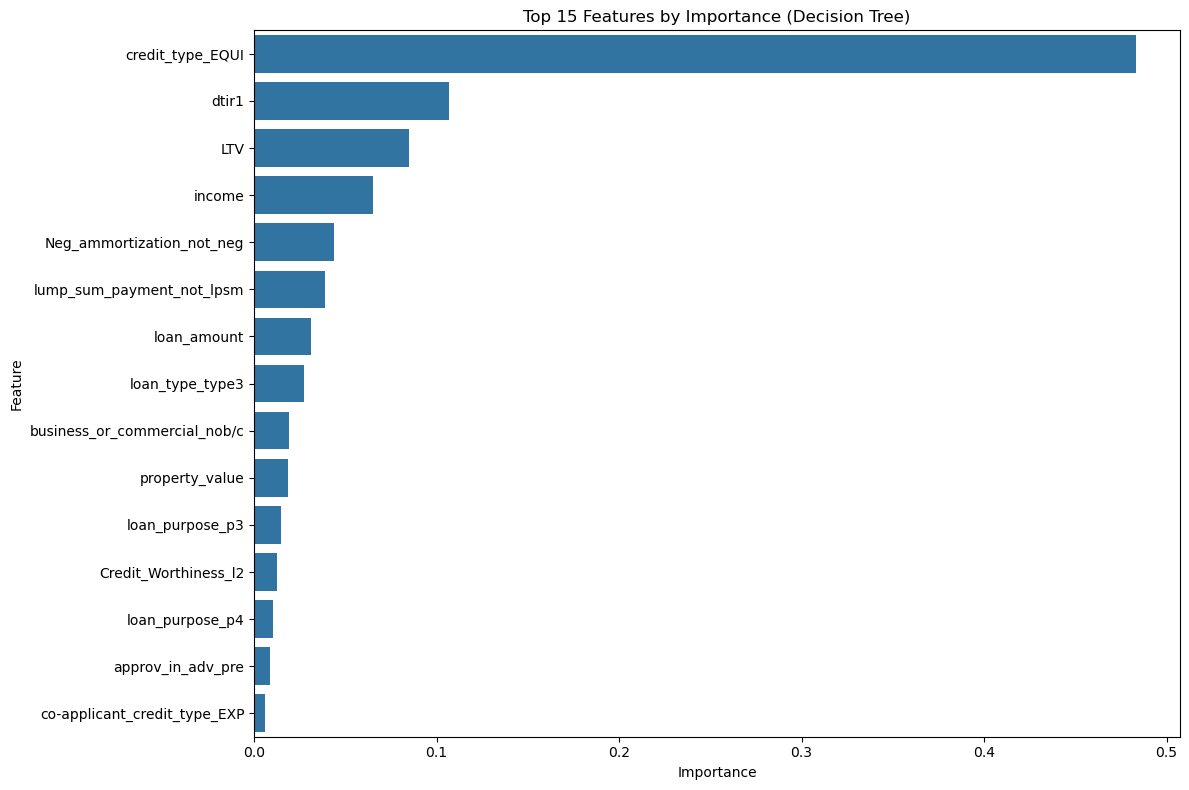

In [78]:
# Show feature importance
dt_feature_importance = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': final_model.feature_importances_
})
dt_feature_importance = dt_feature_importance.sort_values('Importance', ascending=False)

print("Top 20 features by importance:")
print(dt_feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_feature_importance.head(15))
plt.title('Top 15 Features by Importance (Decision Tree)')
plt.tight_layout()
plt.show()

In [88]:
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("----> I am also choosing Decision Tree over Logisitc Regression here because we can visualize and segregate the classifications and splits and even though we cannot directly get the coefficients,\n",
      "we still can visualize why and how are we splitting the tree and make sense out of our predictions and then the recall score and other metrics are higher for the Decision tree as well, so it forms the best choice for us")

print("\n----> I am using Recall as the most important metric here to optimize because in the real world, we want to minimize the number of false negatives and identify the most people who are likely to default.")
print(f"Based on Recall score, the best model is {best_model_name} with an Recall score of {comparison_df.loc[best_model_name, 'f1']:.4f}.")


print("\n----> The final model can now be used for predicting loan defaults on new data.")


CONCLUSION
----> I am also choosing Decision Tree over Logisitc Regression here because we can visualize and segregate the classifications and splits and even though we cannot directly get the coefficients,
 we still can visualize why and how are we splitting the tree and make sense out of our predictions and then the recall score and other metrics are higher for the Decision tree as well, so it forms the best choice for us

----> I am using Recall as the most important metric here to optimize because in the real world, we want to minimize the number of false negatives and identify the most people who are likely to default.
Based on Recall score, the best model is Decision Tree with an Recall score of 0.6987.

----> The final model can now be used for predicting loan defaults on new data.
